In [5]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=1000')

df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col = 'close'

In [7]:
df.drop(["conversionType", "conversionSymbol", "high", "low", "volumeto"], axis = 'columns', inplace = True)
df.head(20)

,open,volumefrom,close
time,,,
2020-10-13,386.91,255939.50,381.41
2020-10-14,381.21,478125.80,379.11
2020-10-15,379.11,591728.69,377.70
2020-10-16,377.82,318744.72,365.58
2020-10-17,365.72,322825.81,368.65
2020-10-18,368.65,359498.81,378.44
2020-10-19,378.44,257142.52,379.41
2020-10-20,379.39,859418.60,368.74
2020-10-21,368.83,731278.91,391.46


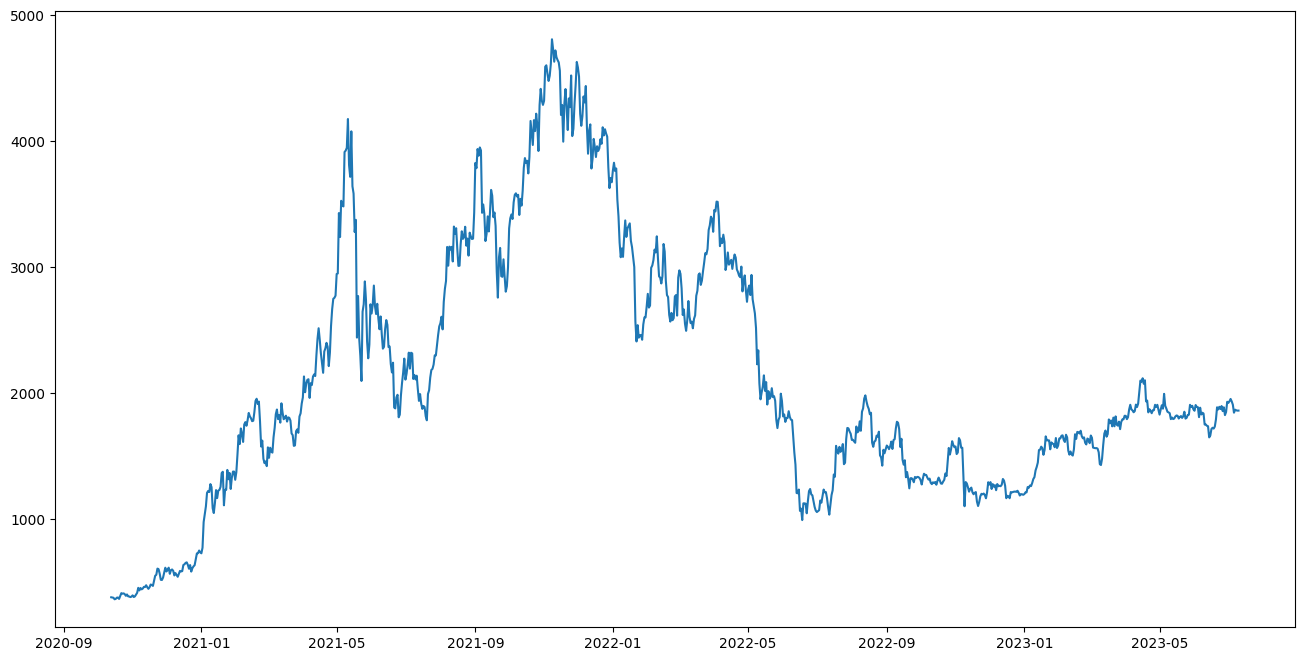

In [8]:
plt.figure(figsize=(16,8))
plt.plot(df[target_col],label='Close Price history')

In [9]:
def train_test_split(df, test_size=0.2) -> pd.DataFrame:
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

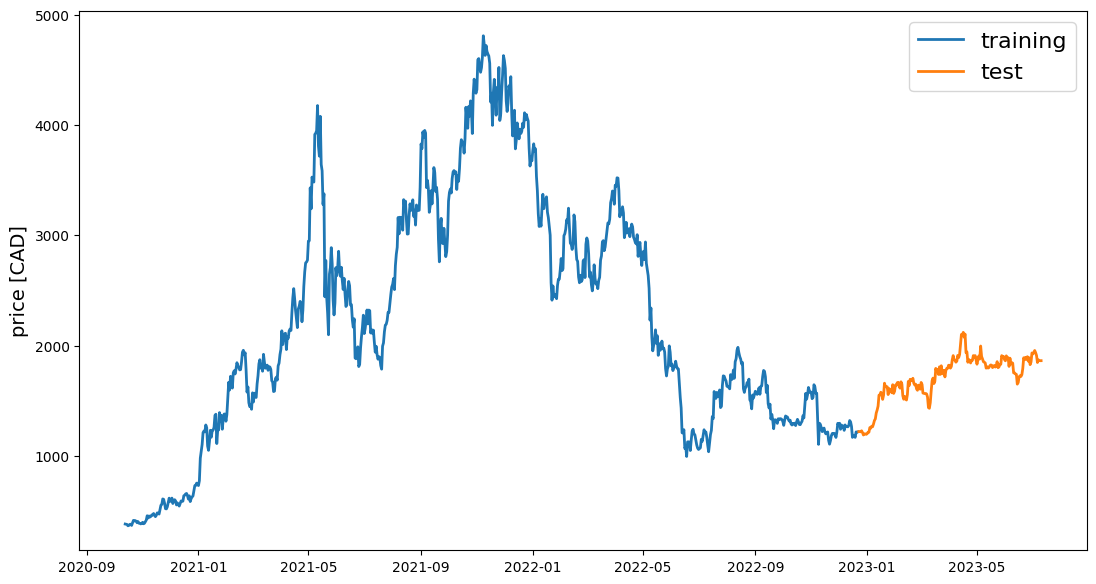

In [11]:
train, test = train_test_split(df)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [144]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [145]:
np.random.seed(42)
window_len = 10
test_size = 0.2
zero_base = True
lstm_neurons = 200
epochs = 30
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [146]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [150]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/30
25/25 [==============================] - 2s 30ms/step - loss: 0.0094 - val_loss: 0.0033
Epoch 2/30
25/25 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 3/30
25/25 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 4/30
25/25 [==============================] - 0s 13ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 5/30
25/25 [==============================] - 0s 15ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 6/30
25/25 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 7/30
25/25 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 8/30
25/25 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 9/30
25/25 [==============================] - 0s 13ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/30
25/25 [==============================] - 0s 15ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 11/

{'loss': [0.009357434697449207, 0.005028802901506424, 0.0038019076455384493, 0.0034044464118778706, 0.003424406284466386, 0.0030983821488916874, 0.0027758677024394274, 0.002817104570567608, 0.002613320481032133, 0.002634035423398018, 0.0027699510101228952, 0.0023229161743074656, 0.0022926072124391794, 0.0022126310504972935, 0.0021985622588545084, 0.002126949140802026, 0.0022349602077156305, 0.0020710425451397896, 0.002124311402440071, 0.0019910128321498632, 0.002075884258374572, 0.0018864860758185387, 0.0018778789089992642, 0.001861079246737063, 0.0018584728240966797, 0.001829122775234282, 0.0018235619645565748, 0.0018524994375184178, 0.001795471296645701, 0.0017090109176933765], 'val_loss': [0.003339203307405114, 0.002891268115490675, 0.0023433519527316093, 0.0015046041226014495, 0.0019597476348280907, 0.0013996049528941512, 0.0021327908616513014, 0.0012166457017883658, 0.0013260693522170186, 0.0012172013521194458, 0.0016039245529100299, 0.0011802600929513574, 0.0009722783579491079, 0

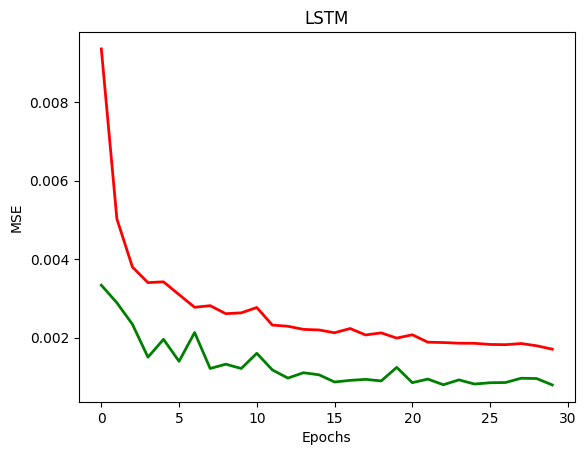

In [151]:
import matplotlib.pyplot as plt
print(history.history)
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [152]:
from sklearn.metrics import mean_absolute_error


targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

6/6 [==============================] - 0s 4ms/step


0.01905568211361798

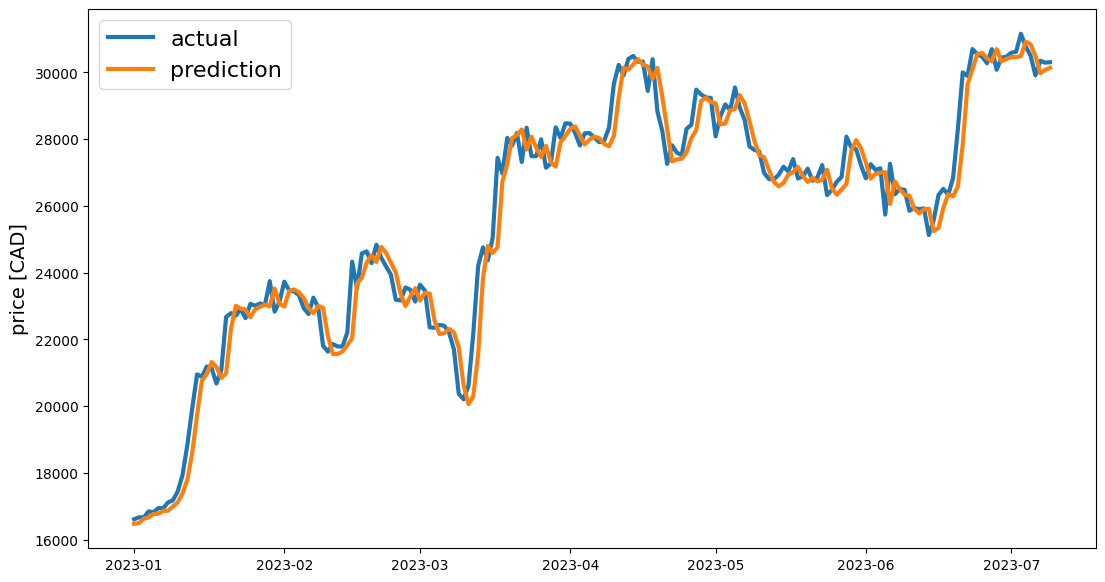

In [153]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [154]:
model.save("crypto_eth_model.h5")

c:\Users\nvtph\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
